In [211]:
RUNNING_IN_COLAB = True
CALCULATE_NUMPY_ARRAY = False

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/tomatodelavegas/recommender-system.git'
    BRANCH   = 'main'
    REPO_DIR = 'recommender-system'
    DATA_URL = 'https://drive.google.com/uc?id=1psSrOGsxFrlj0UJH1Gn6Jee4lEVHX69T'

    from pathlib import Path

    %cd /content

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}
    
    %cd {REPO_DIR}

    # Install requirements
    !pip install -r requirements.txt | grep -v 'Requirement already satisfied'
    !pip install gdown | grep -v 'Requirement already satisfied'
    
    import gdown
    if not Path('ml-25m.zip').is_file():
        gdown.download(DATA_URL, 'ml-25m.zip', quiet=False)
    
    if not Path('ml-25m').is_dir():
        !unzip -q -- ml-25m.zip
if not CALCULATE_NUMPY_ARRAY:
  DATA_URL = 'https://drive.google.com/uc?id=1VxL7shrsYPwEQZdvBs7z25WqhJG9juku'
  if not Path('user_frames_divided.npy').is_file():
    gdown.download(DATA_URL, 'user_frames_divided.npy', quiet=False)

/content
/content/recommender-system


In [212]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# Data
First we load the data

In [213]:
ratings_df = pd.read_csv("ml-25m/ratings.csv")
movies_df = pd.read_csv("ml-25m/movies.csv")

In [214]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [215]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


In [216]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [217]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


## Remove Movies without a genre

In [218]:
nogenres_indexes = movies_df.index[movies_df['genres'] == '(no genres listed)'].tolist()
movieId_todelete = movies_df.iloc[nogenres_indexes]['movieId'].to_numpy()
ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movieId_todelete)].index, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

In [219]:
#movies_df.drop(index=nogenres_indexes,inplace=True)
#movies_df.reset_index(drop=True,inplace=True)

In [220]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [221]:
p_genres = {}
for e in movies_df.itertuples():
    genres_in_row = e[-1].split('|')
    for genre in genres_in_row:
        if genre in p_genres:
            p_genres[genre] += 1
        else:
            p_genres[genre] = 1

In [222]:
p_genres

{'(no genres listed)': 5062,
 'Action': 7348,
 'Adventure': 4145,
 'Animation': 2929,
 'Children': 2935,
 'Comedy': 16870,
 'Crime': 5319,
 'Documentary': 5605,
 'Drama': 25606,
 'Fantasy': 2731,
 'Film-Noir': 353,
 'Horror': 5989,
 'IMAX': 195,
 'Musical': 1054,
 'Mystery': 2925,
 'Romance': 7719,
 'Sci-Fi': 3595,
 'Thriller': 8654,
 'War': 1874,
 'Western': 1399}

In [223]:
del p_genres['(no genres listed)']

In [224]:
# One hot encoding index mask for future genre encoding
one_hot_genres = {}
index_g = 0
for key,val in p_genres.items():
  one_hot_genres[key] = index_g
  index_g += 1

In [225]:
one_hot_genres

{'Action': 7,
 'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Crime': 8,
 'Documentary': 14,
 'Drama': 6,
 'Fantasy': 4,
 'Film-Noir': 18,
 'Horror': 10,
 'IMAX': 13,
 'Musical': 16,
 'Mystery': 11,
 'Romance': 5,
 'Sci-Fi': 12,
 'Thriller': 9,
 'War': 15,
 'Western': 17}

In [226]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [227]:
movies_hot_encoded_genres = np.zeros((len(movies_df), len(one_hot_genres)))
for k in movies_df.itertuples(index=True):
  if k[3] == '(no genres listed)':
    continue
  #0 : index, 1: movieId, 2: title, 3: genres
  # split genres
  genres_split = k[3].split('|')
  for genre in genres_split:
    movies_hot_encoded_genres[k[0], one_hot_genres[genre]] = 1

In [228]:
movies_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [229]:
movies_hot_encoded_genres[0]

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

Nous pouvons observer qu'il existe un imbalance en terme de genres de film avec énormement plus de films de Drama que d'autres.

In [230]:
user_ids = ratings_df["userId"].unique()
nb_user = len(user_ids)
nb_user

162541

In [231]:
import math
def divide_ratings():
  ratings_by_user_dict = dict(tuple(ratings_df.groupby('userId')))
  ratings_by_user = []
  for user_id in tqdm(user_ids):
      
      ratings_of_user = ratings_by_user_dict[user_id]
      ratings_of_user.sort_values(by="timestamp", inplace=True, ignore_index=True)
      
      number_of_ratings = len(ratings_of_user)
      ratings_of_user = ratings_of_user.to_numpy()
      
      # We only keep users with more than 50 ratings
      if number_of_ratings >= 50:
          
          ## We crop to have 25 ratings/frame
          if number_of_ratings % 25 != 0:
              round_number = number_of_ratings % 25
              ratings_of_user = ratings_of_user[:-round_number]
              number_of_ratings = ratings_of_user.shape[0]
          

          dividing_size = number_of_ratings / 25
          
          user_frames = np.split(ratings_of_user, dividing_size)
          
          # Remove the user_id of the data and expand dims
          ratings_by_user.append(np.expand_dims(np.array(user_frames)[...,1:], axis=-1))

  ratings_by_user = np.array(ratings_by_user)
  return ratings_by_user

ratings_by_user = []
if CALCULATE_NUMPY_ARRAY:
  ratings_by_user = divide_ratings()
else:
  ratings_by_user = np.load('user_frames_divided.npy', allow_pickle=True)
ratings_by_user.shape

(102460,)

In [232]:
len(ratings_by_user)

102460

In [233]:
ratings_by_user[0].shape

(2, 25, 3, 1)

In [234]:
ratings_by_user[1].shape

(7, 25, 3, 1)

In [235]:
ratings_by_user[0][0,0,:,0]

array([5.95200000e+03, 4.00000000e+00, 1.14786805e+09])

Add the genres encoded channels on the width.

In [236]:
in_height= ratings_by_user[0].shape[1]
in_width= ratings_by_user[0].shape[2] + len(one_hot_genres)

In [237]:
if CALCULATE_NUMPY_ARRAY:
  np.save("user_frames_divided.npy", ratings_by_user)

In [238]:
column_movieId = movies_df["movieId"]
print("Max ID of movie: ", column_movieId.max())
id_list = column_movieId.to_numpy()

id_dictionnary = sorted(set(id_list))

id_to_index =  {u:i for i, u in enumerate(id_dictionnary)}
index_to_id = list(id_dictionnary)

Max ID of movie:  209171


# Model
Convolutional Tensor-Train LSTM Recommendation Net  
The model was inspired by Covolutional Click Prediction Model (CCPM)  
 We want to vase our recommendation on previous recommendation we made. We want to add the sequential information  
Therefore, we replace the second convolution by a Convolutional Tensor Train LSTM

In [239]:
from utils.convlstmnet import ConvLSTMNet
from torch.nn import Conv2d, AdaptiveMaxPool2d, Linear, Tanh, ReLU, MaxPool2d, Flatten

Hyperparameters for the CTLRN

In [240]:
output_size=len(movies_df) # Number of movies
inputs_channels=1# To define ==> 2
lstm_input_channels=3
cell = "convttlstm"
order = 3
steps = 3
rank = 8
kernel_size = 5
lr=1e-3
output_sigmoid = True

In [241]:
padding_size_w=in_height//2
padding_size_h=in_width//2

In [242]:
ctln_model = ConvLSTMNet(
        # input to the model
        input_channels = lstm_input_channels, 
        # architecture of the model
        layers_per_block = (3, 3, 3, 3), 
        hidden_channels = (32, 48, 48, 32), 
        skip_stride = 2,
        # parameters of convolutional tensor-train layers
        cell = cell, cell_params = {"order": order,
        "steps": steps, "rank": rank},
        # parameters of convolutional operations
        kernel_size = kernel_size, bias = True,
        # output function and output format
        output_sigmoid = output_sigmoid)

In [243]:
class CTLRNet(nn.Module):
    def __init__(self, inputs_channels, output_size):
        super(CTLRNet, self).__init__()
        
        self.inputs_channels = inputs_channels
        self.output_size = output_size
        
        self.conv1 = Conv2d(in_channels=inputs_channels, out_channels=lstm_input_channels,
                       padding=(padding_size_h,padding_size_h), kernel_size=(3,3))
        self.pool1 = AdaptiveMaxPool2d(output_size=(in_height, in_width))
        self.tanh = Tanh()
        self.convttlstm = ctln_model # Espace latent 
        self.pool2 = MaxPool2d(2) # Padding ?
        self.flatten = Flatten()
        self.linear = Linear(in_features=396, out_features=output_size) # 62000
        self.relu = ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.tanh(x)
        
        ## To study exactly
        ## uwu ?
        x = torch.unsqueeze(x, dim=0)
        x = self.convttlstm(x, input_frames = inputs.shape[1], future_frames = 1, output_frames = 1)
        x = torch.squeeze(x, dim=0)
        
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear(x)
        y = self.relu(x)
        return y
        

In [244]:
model = CTLRNet(inputs_channels, output_size)

In [245]:
quick_test_data = ratings_by_user[0]

In [267]:
def add_movies_hot_encoding(data):
  new_data = [ 
              [ 
               movies_hot_encoded_genres[id_to_index[rating[0,0]]] 
              for rating in frame ] 
             for frame in data ]
  return np.concatenate((data, np.expand_dims(np.array(new_data),axis=-1)), axis=2)

In [247]:
quick_test_data_c = add_movies_hot_encoding(quick_test_data)

In [248]:
quick_test_data_c = torch.from_numpy(quick_test_data_c).permute([0,3,1,2])

In [249]:
quick_test_data_c.shape

torch.Size([2, 1, 25, 22])

In [250]:
r = model(quick_test_data_c.float())

In [251]:
r, r.shape

(tensor([[0.0000, 0.0000, 0.4425,  ..., 0.0000, 0.1914, 0.0000]],
        grad_fn=<ReluBackward0>), torch.Size([1, 62423]))

In [252]:
quick_test_data_c[0,0,0]

tensor([5.9520e+03, 4.0000e+00, 1.1479e+09, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64)

# Data Split

To avoid overwhelming the RAM we will only had the one hot encoded genres information at runtime.

In [253]:
np.random.shuffle(ratings_by_user)

data_samples = ratings_by_user.shape[0]

train_size = math.ceil(data_samples * 0.70)
test_size = data_samples - train_size

train_data = ratings_by_user[:train_size][:5000]
test_data = ratings_by_user[train_size:][:1000]

In [254]:
len(train_data),len(test_data)

(5000, 1000)

In [255]:
def split_x_y(data, p=0.25):
    """
    Split and construct a frame into an input and an output
    parameters data: (nb_frames, c, h, w0)
    return: (nb_frames, c, h, w0), (nb_movies)
    """
    data_frames = data.shape[0]
    X_size = math.floor(data_frames * (1-p))
    Y_data_size = data_frames - X_size
    
    
    X = data[:X_size]
    Y_data = data[Y_data_size:]
    
    y = np.zeros(output_size)
    
    #print()
    
    #y[Y_data[...,1]] = Y_data[...,2]
    # Make sure!
    # row[0] = movieId
    # row[1] = rating
    #print(Y_data)
    for frame in Y_data:
        for row in frame[0]:
            y[id_to_index[int(row[0])]] = row[1]
    
    return X, torch.from_numpy(y.reshape(1,-1)).double()
            

In [256]:
x_test, y_test = split_x_y(quick_test_data_c)

In [257]:
x_test.shape

torch.Size([1, 1, 25, 22])

In [258]:
y_test.shape

torch.Size([1, 62423])

# Training

In [259]:
import torch.nn.functional as F

def compute_loss(y_pred, y_true):
    return F.l1_loss(y_pred, y_true, reduction = "mean") + F.mse_loss(y_pred, y_true, reduction = "mean")

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
# whether to use GPU (or CPU) 
use_cuda  = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# whether to use multi-GPU (or single-GPU)
multi_gpu = use_cuda and torch.cuda.device_count() > 1
num_gpus = (torch.cuda.device_count() if multi_gpu else 1) if use_cuda else 0
# move the model to the device (CPU, GPU, multi-GPU) 
model.to(device)
if multi_gpu: 
    model = nn.DataParallel(model)

In [ ]:
# Training loop
num_epochs = 5

loss = 0
history = []
for epoch in range(0, num_epochs):
    loop = tqdm(enumerate(train_data), total = len(train_data))
    running_loss = 0.0
    model.train()
    for batch_idx, frames in loop:
      frames = add_movies_hot_encoding(frames)
      frames = torch.from_numpy(frames).permute([0,3,1,2]).to(device)
      X, y = split_x_y(frames)
      
      optimizer.zero_grad()
      
      pred = model(X.float()).double().to(device)
      y = y.to(device)
      loss = compute_loss(pred, y)
      loss.backward()
      optimizer.step()

      loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
      loop.set_postfix(loss= loss.item())
      running_loss += loss.item()
    history.append(running_loss/len(train_data))

torch.save(model.state_dict(), "checkpoint.pt")

Epoch [4/5]: 100%|██████████| 5000/5000 [04:33<00:00, 18.30it/s, loss=0.00225]


In [ ]:
history

[0.002437077914489326,
 0.002437034469118258,
 0.0024369955579627675,
 0.0022565375009111137,
 0.00224565606587937]

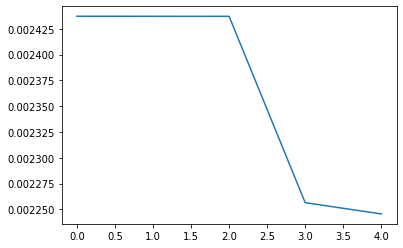

In [ ]:
plt.plot(history)

# Recommender



We firstly add the hot encoding in order to call the model

In [268]:
test_rec0 = add_movies_hot_encoding(test_data[0])

In [269]:
test_data[0].shape

(27, 25, 3, 1)

In [270]:
test_rec0.shape

(27, 25, 22, 1)

In [272]:
test_rec0 = torch.from_numpy(test_rec0).permute([0,3,1,2])

In [274]:
ratings_test_rec0 = model(test_rec0.float())

In [279]:
ratings_test_rec0 = ratings_test_rec0.detach().numpy()

In [288]:
ratings_test_rec0 = np.ndarray.flatten(ratings_test_rec0)

Once the ratings for all the movies found for this particular user, we need to compute which movies were the highest ranked.

In [310]:
def top_recommended(ratings, top_n):
  ratings = np.ndarray.flatten(ratings)
  top_indexes = np.argpartition(ratings, -top_n)[-top_n:]
  top_indexes = top_indexes[np.argsort(ratings[top_indexes])]
  return np.flip(top_indexes)

In [311]:
top_recommended_indexes = top_recommended(ratings_test_rec0, 10)

In [312]:
top_recommended_indexes

array([52265, 11177,  5664, 57302, 36814, 52066, 47973, 19933, 61427,
       21195])

In [313]:
ratings_test_rec0[top_recommended_indexes]

array([1.3220191, 1.3203067, 1.2383199, 1.2281711, 1.1810901, 1.1534708,
       1.12097  , 1.086874 , 1.0717183, 1.0461099], dtype=float32)

What remains is now to display the top movies recommended in the descending order

In [314]:
movies_df.iloc[top_recommended_indexes]

,movieId,title,genres
52265,184915,Daredevils of the Red Circle (1939),Action|Crime
11177,48899,"Man of Straw (Untertan, Der) (1951)",Comedy|Drama
5664,5776,Only When I Laugh (1981),Comedy|Drama
57302,196063,The Indecent Family,(no genres listed)
36814,151210,Graveyard Shift (1987),Horror
52066,184501,Samson (2018),Action|Drama
47973,175705,Themroc (1973),Comedy|Horror
19933,103420,Life Without Dick (2002),Comedy|Crime|Romance
61427,205871,Young Americans (1967),(no genres listed)
21195,109479,Satan's Sword 3: The Final Chapter (Daibosatsu...,Action|Drama
